In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import re

## Importing Textblob package
from textblob import TextBlob

# Importing CountVectorizer for sparse matrix/ngrams frequencies
from sklearn.feature_extraction.text import CountVectorizer

## Import datetime
import datetime as dt
import nltk.compat
import itertools
import chardet

In [34]:

filepath = "bugs-data.csv"
train_incidents = pd.read_csv(filepath,encoding="utf-8")
train_incidents = train_incidents[train_incidents['component'] == 'General']
train_incidents


,bugid,summary,component
12,569063,flash sound stops working until a restart of t...,General
13,570211,Dead keys not working on WYSIWYG editors,General
14,575165,"Mac right click on track pad not working, pull...",General
16,582444,Javascript not working,General
17,584274,Password reminder not working,General
...,...,...,...
2723,616564,"java is not working on firefox, 1001 bugs repo...",General
2727,648921,Upgraded to Firefox 4 ebay countdown clock sto...,General
2728,649837,"Viewing PDF over 5MB in a embed field, is not ...",General
2734,933959,general.useragent.override.[domain] (about:con...,General


In [35]:
train_incidents["summary"] = train_incidents["summary"].apply(lambda x: x.lower())
train_incidents["summary"] = train_incidents["summary"].apply(lambda x: re.sub('http\S+:\/\/.*','',x))
train_incidents["summary"] = train_incidents["summary"].apply(lambda x: re.sub('\w*\d\w*','',x))
train_incidents["summary"] = train_incidents["summary"].apply(lambda x: re.sub(' +',' ',x))
train_incidents["summary"] = train_incidents["summary"].str.replace('[^\w\s]','')

train_incidents["summary"].head(5)

12    flash sound stops working until a restart of t...
13             dead keys not working on wysiwyg editors
14    mac right click on track pad not working pull ...
16                               javascript not working
17                        password reminder not working
Name: summary, dtype: object

In [36]:
#stop = set(stopwords.words('english')) - set(['not'])

In [37]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
train_incidents["summary"] = train_incidents["summary"].apply(lambda x: " ".join(x for x in x.split() 
                                                                                 if x not in stop))
train_incidents["summary"].head(5)

12            flash sound stops working restart browser
13                    dead keys working wysiwyg editors
14    mac right click track pad working pull tab far...
16                                   javascript working
17                            password reminder working
Name: summary, dtype: object

In [38]:
extrastops = ['working','available','properly','availableworking']
train_incidents["summary"] = train_incidents["summary"].apply(lambda y: " ".join(y for y in y.split() 
                                                                                 if y not in extrastops))
train_incidents["summary"].head(5)

12               flash sound stops restart browser
13                       dead keys wysiwyg editors
14    mac right click track pad pull tab far right
16                                      javascript
17                               password reminder
Name: summary, dtype: object

In [39]:
#Common word removal
freq = pd.Series(' '.join(train_incidents['summary']).split()).value_counts()[:3]
freq

##### We will not remove the common word now ####
#freq = list(freq.index)
#train_incidents['summary'] = train_incidents['summary'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
#train_incidents['summary'].head(5)

firefox    188
stops       86
page        68
dtype: int64

In [40]:
#Rare words removal 
freq = pd.Series(' '.join(train_incidents["summary"]).split()).value_counts()[-5:]
freq = list(freq.index)
train_incidents['summary'] = train_incidents['summary'].apply(lambda x: " ".join(x for x in x.split() 
                                                                                 if x not in freq))
train_incidents['summary'].head(5)

12               flash sound stops restart browser
13                       dead keys wysiwyg editors
14    mac right click track pad pull tab far right
16                                      javascript
17                               password reminder
Name: summary, dtype: object

In [41]:
#Stemming - 
#This is example of the results. We prefer lemmatization over Stemming
from nltk.stem import PorterStemmer
st = PorterStemmer()
train_incidents["summary"][:10].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
#train_incidents["summary"] = train_incidents["summary"].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
#train_incidents["summary"].head(40)

12                    flash sound stop restart browser
13                             dead key wysiwyg editor
14        mac right click track pad pull tab far right
16                                          javascript
17                                     password remind
18                                        function key
21                                 copi past text ebay
23    plugin contain stop adob plugin minefield window
24              item list tab without caption mani tab
25                                 flash plugin anymor
Name: summary, dtype: object

In [42]:
#Lemmatization
from textblob import Word
nltk.data.path.append('')
train_incidents["summary"] = train_incidents["summary"].apply(lambda x: " ".join(
                                    [Word(myword).lemmatize(pos="v") for myword in x.split()]))
train_incidents["summary"].head(15)

12                     flash sound stop restart browser
13                             dead key wysiwyg editors
14         mac right click track pad pull tab far right
16                                           javascript
17                                    password reminder
18                                         function key
21                                 copy paste text ebay
23    plugin container stop adobe plugin minefield w...
24            items list tabs without caption many tabs
25                                 flash plugin anymore
26    hide wireless leave mouse button dont work fin...
27                                java script historygo
28                                          java plugin
29                                feedback button click
30                   view mac app store button web link
Name: summary, dtype: object

In [44]:
# We don’t have to calculate TF and IDF every time beforehand and then multiply it to obtain TF-IDF. 
# Instead, sklearn has a separate function to directly obtain it:

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(2,2))
sparse_matrix = tfidf.fit_transform(train_incidents["summary"])
#print (list(sparse_matrix.toarray()))
frequencies = sum(sparse_matrix).toarray()[0]
df_grams = pd.DataFrame(frequencies, index=tfidf.get_feature_names(), columns=['frequency'])
df_grams.sort_values(by = "frequency",ascending=False).head(10)



,frequency
firefox stop,10.726588
right click,6.788241
back button,4.355824
popup blocker,4.286545
button stop,3.764036
web page,3.713350
mouse wheel,3.348493
flash plugin,3.180388
copy paste,3.059461
stop upgrade,3.013213


In [106]:
#Sparsicity is nothing but the percentage of non-zero datapoints in the document-word matrix, that is data_vectorized.
#Since most cells in this matrix will be zero, I am interested in knowing what percentage of cells contain non-zero values.
# Materialize the sparse data
data_dense = sparse_matrix.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.046831489101011495 %


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6]),
 <a list of 9 Text major ticklabel objects>)

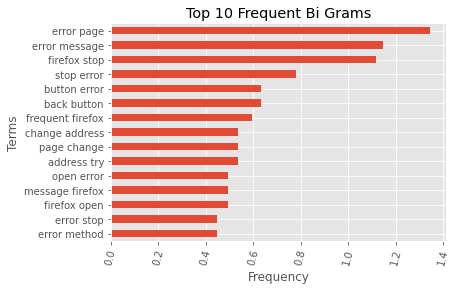

In [66]:
plt.style.use("ggplot")
plt.xlabel("Frequency",)
plt.ylabel("Terms")
trigrams_short_description = df_grams["frequency"].sort_values(ascending = False)
top20_trigrams = df_grams["frequency"].sort_values(ascending = False).head(15)

top5_trigrams_plot =  top20_trigrams.head(15).sort_values(ascending = True).plot(
                                                kind="barh",title = "Top 10 Frequent Bi Grams")
top5_trigrams_plot
plt.xticks(rotation=75)